#Übung 2: Hauptkomponentenanalyse

>####    Einbinden der Packages

Import Standardpakete für die Datenanalyse:  
Numpy für mehrdimensionale Arrays,   
Pandas für Datenanalyse in Tabellen,  
Matplotlib  
Sklearn

In [8]:
!pip3 install pandas numpy wget matplotlib sklearn seaborn pillow

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix, radviz
import os
import wget
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns;
sns.set()
color = sns.color_palette()

#np.__version__, pd.__version__

##1.  Implementierung der Hauptkomponentenanalyse
---
####a) Implementierung eines Python-Modules, das eine Funktion zur Hauptkomponentenanalyse zur Verfügung stellt.

>##### 1.1 Berechnung des Mittelwertes für jedes einzelne Merkmal der Menge von *n* x *d*-dimensionalen Datenpunkten und Abzug dieser von allen Datenpunkten (Zentrierung).

In [9]:
def pca(dataframe, r):
  #PCA Analysis of a given dataframe

  #Parameters
  #----------
  #dataframe : Panda Dataframe
  #A panda dataframe containing the values
  #r : signed integer
  #An positive integer as value for count of principal components

  #Returns
  #-------
  #q_r
  #scores
  #variances
  #sum_variance
  #scores_var
  #exp_var
  #error


  n, d = dataframe.shape

  ## 1.1 Berechnung des Mittelwertes für jedes einzelne Merkmal der Menge von 
  ## n*d-dimensionalen Datenpunkten und Abzug dieses Mittelwertes von allen Datenpunkten
  # Matrix zentrieren
  dataframe_centered = dataframe - dataframe.mean()

  ## 1.2 Normieren aller Merkmale so, dass sie eine Varianz von 1 haben.
  ## While applying StandardScaler, each feature of your data should be normally 
  ## distributed such that it will scale the distribution to a mean of zero and 
  ## a standard deviation of one.
  # Matrix normalisieren, dass Varianz = 1
  standard_scaler = preprocessing.StandardScaler()
  dataframe_scaled = pd.DataFrame(standard_scaler.fit_transform(dataframe_centered))

  ## 1.3 Kopieren aller Datenpunkte in Reihen einer n*d-Matrix (Daten- oder Designmatrix).
  ## Falls nicht schon in vorherigen Schritt geschehen!
  #dataframe_scaled = pd.DataFrame(dataframe_scaled,columns=cols)

  ## 1.4 Lösung des Eigenwertproblenes durch Singulärwertzerlegung der n*d*-Matrix.
  ## M = U*D*V'
  ## U is an m*m real or complex unitary matrix
  ## D is an m*n rectangular diagonal matrix with non-negative real numbers on the diagonal
  ## V is an n*n real or complex unitary matrix
  ## The number of non-zero singular values is equal to the rank of M.
  # Singulärwertzerlegung
  U, d_vector, Vt = np.linalg.svd(dataframe_scaled)
  V = Vt.T # or V=Vt.transpose()

  # d_vector in d*d Form bringen
  D = np.zeros((n-d, d))
  D = np.concatenate((np.diag(d_vector), D))

  # Or
  # D = np.zeros(dataframe.shape)
  # for i in range(len(d_vector)):
  #     D[i, i] = d_vector[i]

  ## 1.5 Die ersten 'r' Basisvektoren 'qi' (d.h die ersten 'r' Hauptkomponenten) 
  ## sind die ersten 'r' Spalten der orthogonalen d*d-Matrix 'V'.
  # Basisvektoren q_r
  q_r = V[:, :r]

  ## 1.6 Die Projektionen 'ai' der Datenpunkte 'xi' auf die ersten 'r' Basisvektoren 'qj' 
  ## (d.h die neuen Variablenwerte im neuen Koordinatensystem) sind die ersten 
  ## 'r' Spalten der n*d-Matrix von 'U*D'.
  # Scores bis 'r' Spalten
  scores = np.matmul(U, D)[:, :r]
  # Kopieren der Scores in Panda Dataframe und Bestimmung der Varianz
  scores_df = pd.DataFrame(scores) # Kovarianz?
  scores_var = scores_df.var()

  # Übrige Scores von 'r' bis 'd' der n*d-Matrix von 'U*D'
  scores_left = np.matmul(U, D)[:, r:]
  # Kopieren der übrigen Scores in Panda Dataframe und Bestimmung der Varianz
  scores_left_df = pd.DataFrame(scores_left)
  scores_left_var = scores_left_df.var()

  ## 1.7 Die Standardabweichungen entlang der Hauptkomponenten 'qi' sind die 
  ## Diagonalelemente der Diagonalmatrix 'D' jeweils geteilt durch n−1.
  # Varianz
  variances = np.power(d_vector, 2) / (n - 1)
  # Summe der Varianzen
  sum_variance = np.sum(variances)

  # Bestimmung des gemachten Fehler's durch die Dimensionsreduktion
  error_p = (np.sum(scores_left_var) / (np.sum(scores_var) + np.sum(scores_left_var)))*100

  # Erklärte Varianz
  exp_var = np.sum(scores_var) / sum_variance

  return q_r, scores, variances, sum_variance, scores_var, exp_var, error_p

####b) Anwenden der Hauptkomponentenanalyse auf den Datensatz "Boston Housing"

In [34]:
# Direkter Download vom ics.uci.de, automatischer Import in Pandas-Dataframe, Abruf des Downloaddatums.
housing_filename = 'housing.data'
if not os.path.isfile(housing_filename):
    print("Downloading file...\n")
    wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', housing_filename)
    dateDownloaded = !date #Calling Linux
    print(dateDownloaded)

# Generierung Tabelle boston
cols = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']
boston = pd.read_csv(housing_filename, sep=' ', skipinitialspace=True, header=None, names=cols + ['TGT'], index_col=False)

# Entfernen von Nullwerten- und doppelten Einträgen
if boston.isna().values.any():
    boston = boston.dropna()

if boston.duplicated().any():
    boston = boston.drop_duplicates()

# Tabelle Boston ohne den Hauspreis 'TGT'
boston_features = boston.drop(['TGT'], axis=1)

# Normierung
boston_norm = (boston - boston.min())/(boston.max() - boston.min())
boston_features_norm = (boston_features - boston_features.min())/(boston_features.max() - boston_features.min())

# Ausgabe statistische Analyse zu Boston Housing
boston_features.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


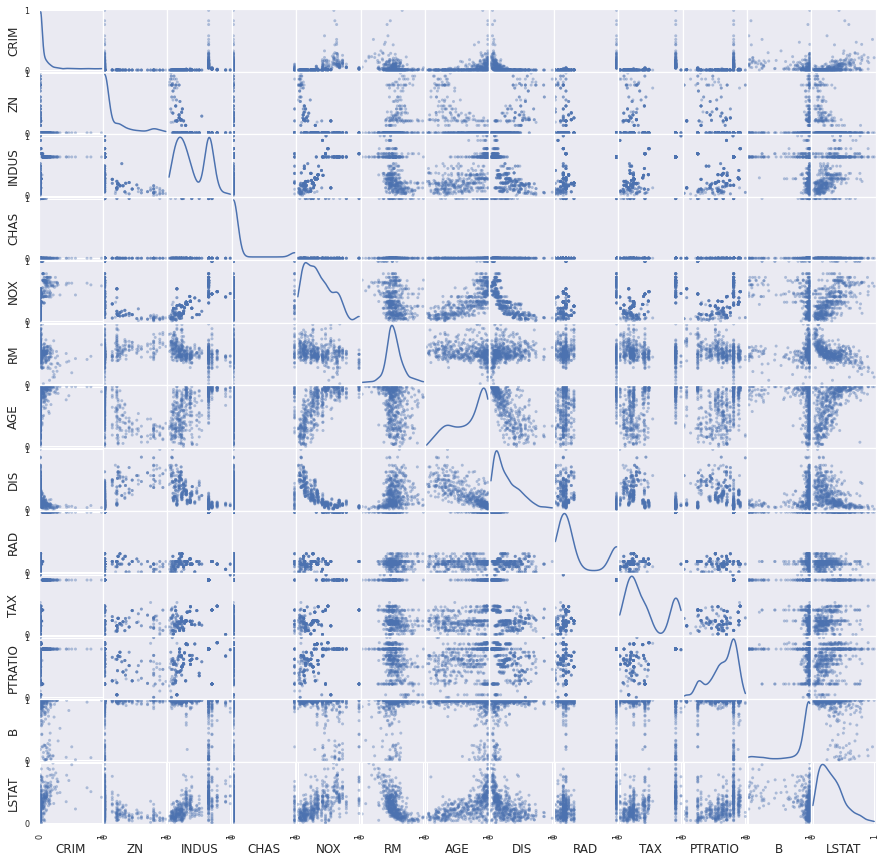

In [4]:
# Scattermatrix Boston Datensatz ohne Hauspreis 'TGT'
scatter_matrix(boston_features_norm, alpha=0.4, figsize=(15, 15), diagonal='kde');

Die Ergebnisse sind in einer Tabelle mit den Eigenwerten der Kovarianzmatrix, dem Anteil der zugehörigen Hauptkomponente an der Gesamtvarianz (“erklärte Varianz”) und der kumulativen erklärten Varianz dargestellt.

In [69]:
table = []

for r in range(1, boston_features.shape[1]+1):
      q_r, scores, std_abweichung, ges_var, scores_var, exp_var, error_p = pca(boston_features, r)
      table.append({'Hauptkomponente': r, 'erklärte Varianz': np.sum(scores_var), 'kumulativ erklärte Varianz': exp_var, 'Fehler [%]': error_p})      
table = pd.DataFrame(table)
table

,Hauptkomponente,erklärte Varianz,kumulativ erklärte Varianz,Fehler [%]
0,1,6.138981,0.471296,52.870394
1,2,7.575094,0.581548,41.845200
2,3,8.820172,0.677134,32.286611
3,4,9.679445,0.743101,25.689879
4,5,10.515914,0.807318,19.268218
5,6,11.174623,0.857888,14.211240
6,7,11.711039,0.899069,10.093116
7,8,12.107921,0.929538,7.046214
8,9,12.385413,0.950841,4.915880
9,10,12.606087,0.967783,3.221743


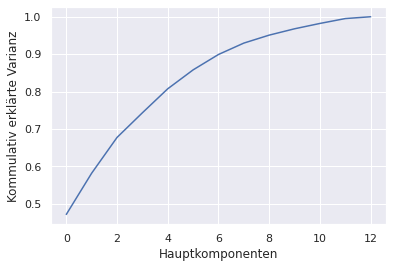

In [68]:
plt.plot(table.iloc[:,2])
plt.xlabel('Hauptkomponenten')
plt.ylabel('Kommulativ erklärte Varianz');

#####Frage: Wieviele Dimensionen können Sie weglassen,wenn Sie 10%, 5% und 1% Fehler bei der Dimensionsreduktion zulassen?


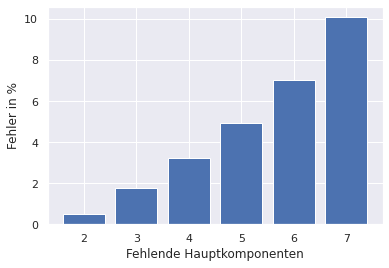

In [60]:
dim_reduct = []

for r in range(1, boston_features.shape[1]+1):
    q_r, scores, std_abweichung, ges_var, scores_var, exp_var, error_p = pca(boston_features, r)
    if error_p > 0:
      if error_p <= 1:
        dim_reduct.append({'Fehlende Hauptkomponenten': 14-r, 'Fehler [%]': error_p})
      if error_p <= 5:        
        dim_reduct.append({'Fehlende Hauptkomponenten': 14-r, 'Fehler [%]': error_p})
      if error_p <= 11:
        dim_reduct.append({'Fehlende Hauptkomponenten': 14-r, 'Fehler [%]': error_p})

dim_reduct = pd.DataFrame(dim_reduct)
dim_reduct = dim_reduct.drop_duplicates()

# Gemachter Fehler bei x weggelassenen Hauptkomponenten in % 
plt.bar(dim_reduct.iloc[:,0], dim_reduct.iloc[:,1])
plt.ylabel("Fehler in %");
plt.xlabel("Fehlende Hauptkomponenten");

####c) Berechnung des Korrelationskoeffizienten der Projektionen auf die ersten drei Hauptkomponenten mit den ursprünglichen Variablen

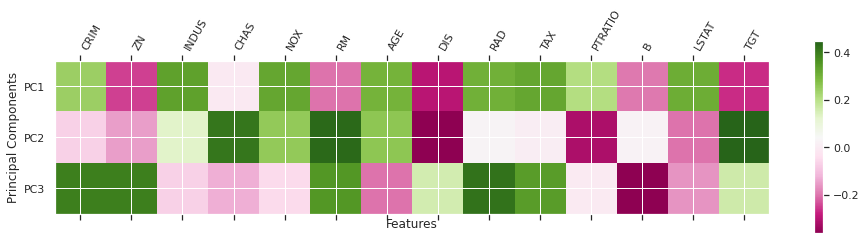

In [51]:
q_r, _, _, _, _, _, _ = pca(boston, 3)
plt.matshow(q_r.T, cmap='PiYG')
plt.yticks([0, 1, 2], ["PC1", "PC2", "PC3"])
plt.xticks(range(len(list(boston_norm))), list(boston_norm), rotation=60, ha='left')
plt.xlabel("Features")
plt.ylabel("Principal Components")
plt.colorbar();

Ergebnis:

###d) Darstellung der ersten beiden neuen Variablen als Scatterplot
Dabei sind alle Datenpunkte mit einem Hauspreis oberhalb des Medians aller Hauspreise in rot dargestellt - die Datenpunkte unterhalb des Medians in blau.

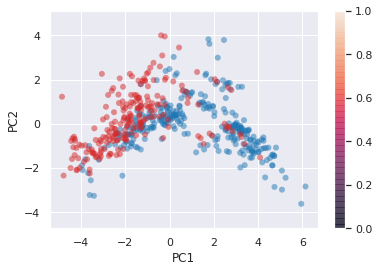

In [50]:
_, scores, _, _, _, _, _ = pca(boston_features, 2)

scores_df = pd.DataFrame(scores, columns=["PC1", "PC2"])
scores_df = pd.concat([scores_df, boston_norm['TGT']], axis=1, sort=False)

tgt_below_mean = scores_df[scores_df['TGT'] < scores_df['TGT'].mean()]
tgt_above_mean = scores_df[scores_df['TGT'] >= scores_df['TGT'].mean()]

plt.scatter(x=tgt_below_mean['PC1'], y=tgt_below_mean['PC2'], c='tab:blue', edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral',10))
plt.scatter(x=tgt_above_mean['PC1'], y=tgt_above_mean['PC2'], c='tab:red', edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.ylabel("PC2")
plt.xlabel("PC1")
plt.axis('equal')
plt.colorbar();

####Frage: Eignen sich die beiden neuen Variablen zur Vorhersage des Hauspreises?

Ergebnis:

##2.  Eigengesichter
---
####a) Laden des “Labeled Faces in the Wild” Datensatzes. Durchsuchen der Verzeichnisse des Datensatzes zur Ermittlung der Personen, für die mindestens 70 Bilder existieren.

In [3]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


In [6]:
from sklearn.decomposition import PCA as RandomizedPCA
pca = RandomizedPCA(n_components=150, svd_solver='randomized', whiten=True).fit(faces.data)
pca

PCA(n_components=150, svd_solver='randomized', whiten=True)

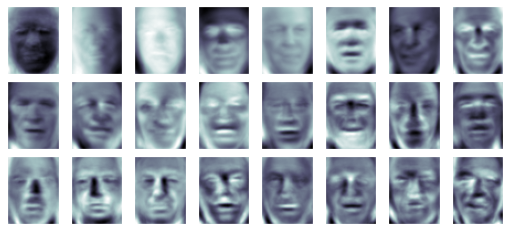

In [9]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
  subplot_kw={'xticks':[], 'yticks':[]},
  gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
  ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

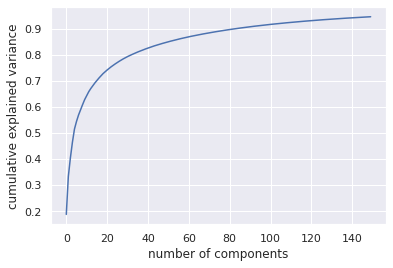

In [10]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [11]:
# Compute the components and projected faces
pca = RandomizedPCA(150).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

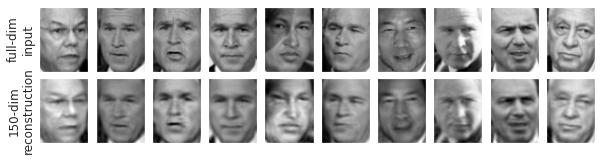

In [13]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
  subplot_kw={'xticks':[], 'yticks':[]},
  gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
  ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
  ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')

ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

In [35]:
# Import
import pandas as pd
import numpy as np
import os
import wget
import tarfile
from sklearn import *
from skimage import io
from skimage.transform import rescale, resize
from matplotlib import pyplot as plt

In [24]:
# Variables
url = 'http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz'
tgz_file = 'lfw_funneled.tgz'
images_folder = os.path.join(os.getcwd(), 'lfw_funneled')

In [29]:
# Download Function
def download_file(url):
#
  if not os.path.isfile(tgz_file):
      print("Downloading file...\n")
      wget.download(url, tgz_file)
      dateDownloaded = !date #Calling Linux
      print("File downloaded on:", dateDownloaded[0])
  else:
      print("File already exists!\n")

In [26]:
# Extract Function
def extract():

  try:
      print("Extracting...")
      tar = tarfile.open(tgz_file, "r:gz")
      tar.extractall()
      print("Files extracted")
      tar.close()
  except:
      print("Extraction failed! Something went wrong.")

In [30]:
# Finding chosen images function
def find_images():
  list_of_persons = []
  if not os.path.isdir(images_folder):
      if not os.path.isfile(tgz_file):
          download_file(url)
      else:
          print("tgz-File exists")
          extract()
  else:
      for folder in os.listdir(images_folder):
          subfolder = os.path.join(images_folder, folder)
          if os.path.isdir(subfolder):
              count = len(os.listdir(subfolder))
              if count >= 70:
                  list_of_persons.append(folder)
                  print("{} with {} images".format(folder, count))

In [31]:
download_file(url)

File already exists!



In [32]:
find_images()

Hugo_Chavez with 71 images
Gerhard_Schroeder with 109 images
Colin_Powell with 236 images
Tony_Blair with 144 images
George_W_Bush with 530 images
Donald_Rumsfeld with 121 images
Ariel_Sharon with 77 images


Number of different faces 7
Total number of faces 1288


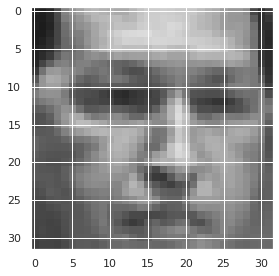

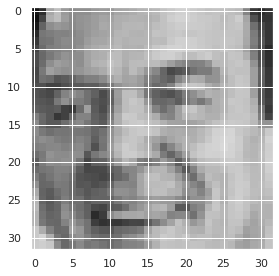

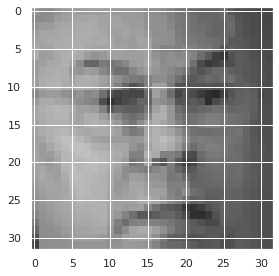

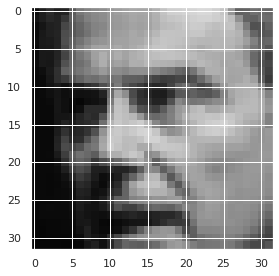

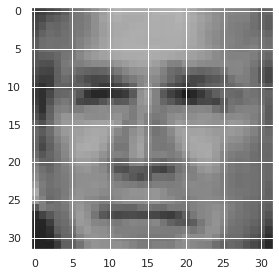

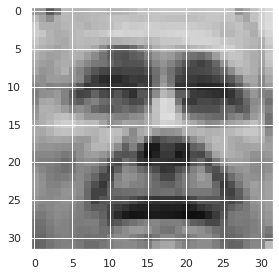

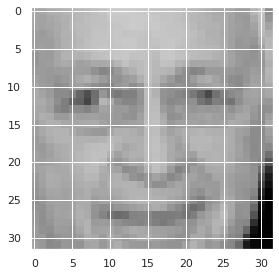

In [38]:
faces_paths = []
faces_no = 0

for subdir, dirs, files in os.walk(images_folder):
    if len(dirs) == 0:
        if len(files) >= 70:
            faces_paths.append(subdir)
            faces_no += len(files)

print("Number of different faces", len(faces_paths))
print("Total number of faces", faces_no)

test_faces = []

for faces_path in faces_paths:
    label = os.path.split(faces_path)[-1]
    faces = [files for _, _, files in os.walk(faces_path)][0]
    faces.sort()
    
    test_faces.append(os.path.join(faces_path, faces.pop()))

    for face in faces:
        face_path = os.path.join(faces_path, face)

        face_ndarray = io.imread(face_path, as_gray=True)
        face_ndarray = face_ndarray[75:175,75:175]
        face_ndarray = resize(face_ndarray, (32, 32))

        io.imshow(face_ndarray)
        plt.show()
        break



In [39]:
"""It helps visualising the portraits from the dataset."""
def plot_portraits(images, titles, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
        #images_folder

In [53]:
dir=images_folder
celebrity_photos=os.listdir(dir)[1:1001]
celebrity_images=[dir+'/' + photo for photo in celebrity_photos]
celebrity_images
images=np.array([plt.imread(image) for image in celebrity_images], dtype=np.float64)
#celebrity_names=[name[:name.find('0')-1].replace("_", " ") for name in celebrity_photos]
#n_samples, h, w = images.shape
#plot_portraits(images, celebrity_names, h, w, n_row=4, n_col=4)

IsADirectoryError: ignored

In [ ]:
def pca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    U, S, V = np.linalg.svd(centered_data)
    components = V[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc]
                                
    return projected, components, mean, centered_data

In [ ]:
n_components = 50
X = images.reshape(n_samples, h*w)
P, C, M, Y= pca(X, n_pc=n_components)
eigenfaces = C.reshape((n_components, h, w))
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_portraits(eigenfaces, eigenface_titles, h, w, 4, 4) 

In [ ]:
def reconstruction(Y, C, M, h, w, image_index):
    n_samples, n_features = Y.shape
    weights = np.dot(Y, C.T)
    centered_vector=np.dot(weights[image_index, :], C)
    recovered_image=(M+centered_vector).reshape(h, w)
    return recovered_image
recovered_images=[reconstruction(Y, C, M, h, w, i) for i in range(len(images))]
plot_portraits(recovered_images, celebrity_names, h, w, n_row=4, n_col=4)

####b. Laden alle Bilder (bis auf eines pro Person - zum späteren Testen des Klassifikators) der am Häufigsten abgebildeten Personen in Vektoren und erstellen einer gemeinsamen Designmatrix daraus. Umwandeln der Farbbilder in Grauwerte. Zuschneiden eines einheitlichen zentralen Ausschnitt (bestehend aus Augen und Mund) und skalieren der Bilder auf die Größe von 32×32 Pixel. Anlegen eines zusätzlichen Vektores, in dem der Name der Person (d.h. der Ordnername) für jede Zeile steht. Durchführung auf die gleiche Art der Verarbeitung mit dem übrig gebliebenen Testbildern pro Person und getrennte Speicherung dieser.

###c. Anwendung der Hauptkomponentenanalyse auf die Designmatrix. Darstellung der ersten 150 Eigenwerte in einem Diagramm. Darstellung der ersten 12 Eigengesichter durch Umformung der gestackten Bilder in das ursprüngliche Format. Interpretieren Sie das Ergebnis.

###d. Abziehen des Mittelwertes der Trainingsdaten von den Testbildern. Projizieren jeder der Trainings- und Testbilder auf die ersten 7 Eigengesichter. Gesichtserkennung durch Berechnung des euklidischen Abstand des Testbildes im 7-dimensionalen Merkmalsraum zu allen Trainingsbildern. (Die Persondes am nächsten liegenden Trainingsbildes (d.h. mit dem minimalen euklidischen Abstand) ist dann (vermutlich) auch die korrekte Person für das Testbild (Nächster-Nachbar-Klassifikator)). Frage: Welche Bilder werden korrekt klassifiziert, welche Verwechslungen gibt es?